In [112]:
import numpy as np
import math
from math import pi
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

from scipy.special import iv
from scipy.linalg import expm, block_diag
from scipy import integrate
from openfermion import fermi_hubbard, jordan_wigner, get_sparse_operator
from collections import Counter

from qiskit import QuantumCircuit, QuantumRegister
from qiskit import Aer, transpile
from qiskit.circuit import Parameter
from qiskit.providers.fake_provider import FakeGuadalupe, FakeNairobi
from qiskit.visualization import plot_histogram



In [127]:
from qiskit import IBMQ

#IBMQ.save_account('')
IBMQ.load_account()
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='qhack-hackathon', project='7-qubit')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='qhack-hackathon', project='16-qubit')>,
 <AccountProvider for IBMQ(hub='qhack-event', group='main', project='level-1')>,
 <AccountProvider for IBMQ(hub='qhack-event', group='main', project='level-2-team-4')>]

In [124]:
hubbard = fermi_hubbard(1, 2, 1, 4, periodic=False,particle_hole_symmetry=True)
jw_hamiltonian = jordan_wigner(hubbard)
jw_hamiltonian = jordan_wigner(hubbard)
fh_matrix = get_sparse_operator(jw_hamiltonian)
fh_matrix = fh_matrix.todense()
fh_matrix = fh_matrix.real

norm = np.linalg.norm(fh_matrix)
tau = 3*np.pi/(4*norm)

In [122]:
def get_real_CDF(N_sites, t, U, tau, precision, initial_state_symmetry=True):

    hubbard = fermi_hubbard(1, N_sites, t, U, periodic=False,particle_hole_symmetry=True)
    jw_hamiltonian = jordan_wigner(hubbard)
    fh_matrix = get_sparse_operator(jw_hamiltonian)
    fh_matrix = fh_matrix.todense()
    fh_matrix = fh_matrix.real
    norm = np.linalg.norm(fh_matrix)
    #tau = np.pi/(4*norm)
    
    Ndim = 2**(2*N_sites)
    energy, eigenstate= np.linalg.eig(tau*fh_matrix)

    hf_state = np.zeros(Ndim)


    if initial_state_symmetry:
        index_1 = int('0110'*(N_sites//2),2)
        index_2 = int('1001'*(N_sites//2),2)
        hf_state[index_1], hf_state[index_2] = 1/np.sqrt(2), 1/np.sqrt(2)
    else:
        hf_index = 0
        for i in range(N_sites):
            if i%2==0:
                hf_index += 2**(2*i)
            elif i%2!=0:
                hf_index += 2**(2*i+1)
        hf_state[hf_index] = 1

    energy=energy.real
    eigenstate[np.abs(eigenstate)<1e-10]=0
    eigenstate = np.array(eigenstate)

    prob_raw = np.zeros(Ndim)
    for i in range(Ndim):
        prob_raw[i] = np.abs(np.dot(hf_state,eigenstate[:,i]))**2
    prob = []
    ener = []
    for i,ele in enumerate(prob_raw):
        if ele!=0:
            prob.append(ele)
            ener.append(energy[i].real)

    x_list = np.linspace(-np.pi/3, np.pi/3, precision)
    CDF = np.zeros(len(x_list))

    for j,ener_ele in enumerate(ener):
        for i,x_ele in enumerate(x_list):
            if x_ele>ener_ele:
                CDF[i] += prob[j]

    return CDF

In [114]:
## Get Trotterization Hamiltonian Evolution Gate:

def fh_evolution(N_sites, t, U, tau, j, step, to_gate=True):
    
    qr = QuantumRegister(2*N_sites,'qr')
    qc = QuantumCircuit(qr)
    
    for _ in range(step):
        
        ## Hopping terms 
        #theta = tau*t*j/step
        theta = Parameter('theta')
        
        for i in range(N_sites//2):
            qc.rxx(theta,2*i,2*i+1)
            qc.ryy(theta,2*i,2*i+1)

            qc.rxx(theta,2*i+N_sites,2*i+1+N_sites)
            qc.ryy(theta,2*i+N_sites,2*i+1+N_sites)
            
        for i in range((N_sites-1)//2):
            qc.rxx(theta,2*i+1,2*i+2)
            qc.ryy(theta,2*i+1,2*i+2)

            qc.rxx(theta,2*i+N_sites+1,2*i+2+N_sites)
            qc.ryy(theta,2*i+N_sites+1,2*i+2+N_sites)
        
        ## Potential
        #gamma = tau*j*U/(2*step)
        gamma = Parameter('gamma')
        
        for i in range(N_sites):
            qc.rzz(gamma,i,i+N_sites)
    return qc.to_gate() if to_gate else qc

In [129]:
def fh_evolution_para(N_sites, theta_para, gamma_para, step, to_gate=True):
    
    qr = QuantumRegister(2*N_sites,'qr')
    qc = QuantumCircuit(qr)
    
    for _ in range(step):
        
        ## Hopping terms 
        #theta = tau*t*j/step
        #theta = Parameter('theta')
        
        for i in range(N_sites//2):
            qc.rxx(theta_para,2*i,2*i+1)
            qc.ryy(theta_para,2*i,2*i+1)

            qc.rxx(theta_para,2*i+N_sites,2*i+1+N_sites)
            qc.ryy(theta_para,2*i+N_sites,2*i+1+N_sites)
            
        for i in range((N_sites-1)//2):
            qc.rxx(theta_para,2*i+1,2*i+2)
            qc.ryy(theta_para,2*i+1,2*i+2)

            qc.rxx(theta_para,2*i+N_sites+1,2*i+2+N_sites)
            qc.ryy(theta_para,2*i+N_sites+1,2*i+2+N_sites)
        
        ## Potential
        #gamma = tau*j*U/(2*step)
        #gamma = Parameter('gamma')
        
        for i in range(N_sites):
            qc.rzz(gamma_para,i,i+N_sites)
    return qc.to_gate() if to_gate else qc

In [128]:
#fh_evolution(4,1,4,1,1,1,False).draw('mpl')

In [113]:
A = Parameter('theta')

In [18]:
def initial_state_prep(N_sites, initial_state_symmetry=True, to_gate=True):

    qr = QuantumRegister(2*N_sites,'qr')
    qc = QuantumCircuit(qr)

    if initial_state_symmetry:
        qc.h(0)
        for i in range(N_sites):
            if i%2!=0:
                qc.x(i)
            else:
                qc.x(i+N_sites)

        qc.cnot(0,range(1,2*N_sites))

    else:
        for i in range(N_sites):
            if i%2!=0:
                qc.x(i)
            else:
                qc.x(i+N_sites)
        

    return qc.to_gate() if to_gate else qc

In [34]:
def get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, initial_state_symmetry=True,test_type='real'):

    qr = QuantumRegister(2*N_sites+2,'qr')
    qc = QuantumCircuit(qr)

    qc.h([0,1])
    if test_type=='real':
        pass
    elif test_type=='imag':
        qc.s(0)

    
    prep_gate = initial_state_prep(N_sites=N_sites,initial_state_symmetry=initial_state_symmetry)
    qc.append(prep_gate.control(), [0]+list(range(2,2*N_sites+2)))

    evolution_gate = fh_evolution(N_sites=N_sites, t=t, U=U, tau=tau, j=j, step=step)
    qc.append(evolution_gate,range(2,2*N_sites+2))

    prep_gate_conj = prep_gate.reverse_ops()
    qc.append(prep_gate_conj.control(), [1]+list(range(2,2*N_sites+2)))

    qc.h([0,1])

    qc.measure_all()

    return qc

In [130]:
def get_new_Hadamard_circuit_para(N_sites, theta_para, gamma_para, step, initial_state_symmetry=True,test_type='real'):

    qr = QuantumRegister(2*N_sites+2,'qr')
    qc = QuantumCircuit(qr)

    qc.h([0,1])
    if test_type=='real':
        pass
    elif test_type=='imag':
        qc.s(0)

    
    prep_gate = initial_state_prep(N_sites=N_sites,initial_state_symmetry=initial_state_symmetry)
    qc.append(prep_gate.control(), [0]+list(range(2,2*N_sites+2)))

    evolution_gate = fh_evolution_para(N_sites=N_sites, theta_para=theta_para, gamma_para=gamma_para, step=step)
    qc.append(evolution_gate,range(2,2*N_sites+2))

    prep_gate_conj = prep_gate.reverse_ops()
    qc.append(prep_gate_conj.control(), [1]+list(range(2,2*N_sites+2)))

    qc.h([0,1])

    qc.measure_all()

    return qc 

In [139]:
theta= Parameter('theta')
gamma =Parameter('gamma')
qc = get_new_Hadamard_circuit_para(4,theta,gamma,1,initial_state_symmetry=False).decompose()
A=qc.bind_parameters({theta:0.1,gamma:0.2})
#A.draw('mpl')

In [116]:
#backend=Aer.get_backend('qasm_simulator')
backend = FakeGuadalupe()
#backend = FakeNairobi()

In [117]:
qc = get_new_Hadamard_circuit(4,1,4,1,1,1,initial_state_symmetry=False)

qc = transpile(qc,backend,optimization_level=3)

##res = job.result()

In [140]:
#qc.draw('mpl')

In [147]:
#qc.draw('mpl',scale=0.5)
qc.name='test'
qc.name

'test'

In [150]:
#qc.draw('mpl')

In [141]:
#qc.draw('mpl',scale=0.5)

In [62]:
def get_new_Z(N_sites, t, U, tau, j, step, shots, initial_state_symmetry=True):

    qc_real = get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, initial_state_symmetry=initial_state_symmetry, test_type='real')
    qc_imag = get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, initial_state_symmetry=initial_state_symmetry, test_type='imag')
    backend=Aer.get_backend('qasm_simulator')

    qc_real = transpile(qc_real,backend)
    qc_imag = transpile(qc_imag,backend)
    job_real = backend.run(qc_real,shots=shots)
    job_imag = backend.run(qc_imag,shots=shots)
    
    counts_real = job_real.result().get_counts()
    counts_imag = job_imag.result().get_counts()

    p00, p01, p10, p11 = 0,0,0,0
    if ('0'*2*N_sites+'00') in counts_real.keys():
        p00 = counts_real['0'*2*N_sites+'00']/shots
    if ('0'*2*N_sites+'01') in counts_real.keys():
        p01 = counts_real['0'*2*N_sites+'01']/shots
    if ('0'*2*N_sites+'10') in counts_real.keys():
        p10 = counts_real['0'*2*N_sites+'10']/shots
    if ('0'*2*N_sites+'11') in counts_real.keys():
        p11 = counts_real['0'*2*N_sites+'11']/shots

    X = p00+p11-p01-p10

    p00, p01, p10, p11 = 0,0,0,0
    if ('0'*2*N_sites+'00') in counts_imag.keys():
        p00 = counts_imag['0'*2*N_sites+'00']/shots
    if ('0'*2*N_sites+'01') in counts_imag.keys():
        p01 = counts_imag['0'*2*N_sites+'01']/shots
    if ('0'*2*N_sites+'10') in counts_imag.keys():
        p10 = counts_imag['0'*2*N_sites+'10']/shots
    if ('0'*2*N_sites+'11') in counts_imag.keys():
        p11 = counts_imag['0'*2*N_sites+'11']/shots

    Y = p00+p11-p01-p10

    lambda_R = U/4*N_sites

    Z = 2*(X-1j*Y)*np.exp(-1j*lambda_R*j*tau)
    return Z

In [71]:
def get_shots_per_run(F_list, total_shots):

    F_list_abs = np.array([np.abs(ele) for ele in F_list])
    probs = F_list_abs/sum(F_list_abs)
    sampling = np.random.choice(range(len(probs)), size=int(total_shots), p=probs)
    counter = Counter(sampling)

    shots_list = np.zeros(len(probs),dtype=int)
    for i in range(len(probs)):
        shots_list[i] = int(counter[i])

    #shots_per_run = np.round(total_shots*probs)
    return shots_list#shots_per_run

def get_Z_list(d, N_sites, t, U, tau, step, shots_list, initial_state_symmetry=True): ## shots_per_run should be replaced
    
    #Z_list = [get_new_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_list) for j in range(d+1)]

    Z_list = np.zeros(d+1,dtype='complex')
    for j in range(d+1):
        if shots_list[j]:
            Z_list[j] = get_new_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_list[j],initial_state_symmetry=initial_state_symmetry)
    return Z_list

In [151]:
def get_circuit_list_to_run(N_sites,t,U,tau,step,shots_list,backend,initial_state_symmetry=True):

    circ_list = []
    theta = Parameter('theta')
    gamma = Parameter('gamma')
    circ_para = get_new_Hadamard_circuit_para(N_sites,theta_para=theta, gamma_para=gamma, step=step, initial_state_symmetry=initial_state_symmetry)

    circ_transpiled = transpile(circuits=circ_para, backend=backend, optimization_level=3)
    for j, shot in enumerate(shots_list):
        theta_value = tau*t*(2*j+1)/step
        gamma_value = tau*U*(2*j+1)/(2*step)
        circ_binded = circ_transpiled.bind_parameters({theta:theta_value,gamma:gamma_value})
        circ_binded.name = 'circ=-='+str(j)
        circ_list.append(circ_binded)
    
    return circ_list

In [181]:
provider = IBMQ.get_provider(hub='qhack-event',project='level-1')
backend=provider.get_backend('ibmq_jakarta')

In [182]:
#backend = FakeGuadalupe()
circ_list = get_circuit_list_to_run(2,1,4,.05,1,[3,1,2],backend=backend,initial_state_symmetry=False)
job = backend.run(circ_list, shots=2048)

In [183]:
res = job.result()
res.results[0]

In [72]:
def Assembly_ACDF(Z_list, F_list, precision):
    
    ACDF = .5*np.ones(precision)
    x_list = np.linspace(-pi,pi,precision)
    d = len(F_list)-1
    
    for j in range(d+1):
        ACDF = ACDF + F_list[j]*Z_list[j]*np.exp(1j*(2*j+1)*x_list) - F_list[j]*Z_list[j].conj()*np.exp(-1j*(2*j+1)*x_list)
        #ACDF = ACDF + F_list[j]*Z_list[j]*2j*np.sin((2*j+1)*x_list)
                                                                              
    return ACDF

In [74]:
F_list_import = np.load('F_list_d2e4_lim1e4.npy')

In [142]:
get_shots_per_run(F_list=F_list_import, total_shots=3e3)

array([551, 186, 133, ...,   0,   0,   0])

In [78]:
shots_list = get_shots_per_run(F_list=F_list_import, total_shots=3e3)
Z_list = get_Z_list(20000, 4, 1, 4, tau, 4, shots_list)

/Users/dranz/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/dranz/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [79]:
ACDF = Assembly_ACDF(Z_list, F_list_import, 100000)

/Users/dranz/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-0.5, -0.3)

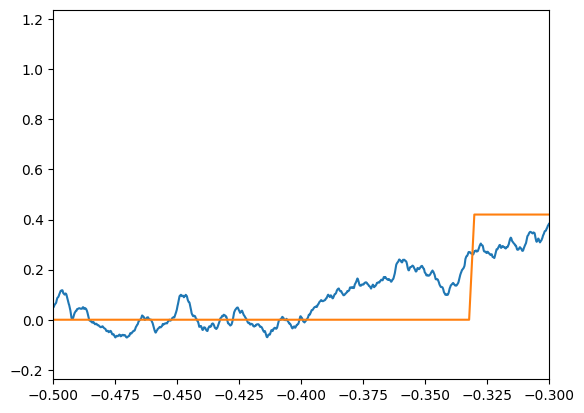

In [83]:
plt.plot(np.linspace(-pi,pi,100000), ACDF)
#plt.plot(np.linspace(-pi,pi,10000), ACDF_2)
plt.plot(np.linspace(-np.pi/3, np.pi/3, 1000), get_real_CDF(4,1,4, tau,precision=1000), label='CDF')
#plt.xlim([-pi/3, pi/3])
plt.xlim([-0.5,-0.3])